<a href="https://colab.research.google.com/github/pedrosena138/assin2-bertimbau-benchmark/blob/main/ASSIN2_Portuguese_BERT_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Install dependencies

In [ ]:
# Install libs
!pip install datasets transformers evaluate huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

Checking if transformers lib version is gratter then 4.16.0

In [ ]:
import transformers

assert transformers.__version__ > '4.16.0'
print(transformers.__version__)

4.28.1


In [ ]:
import json
import tensorflow as tf
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
from datasets import load_dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, create_optimizer, pipeline
import evaluate

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Plot style
mpl.rcParams['figure.figsize'] = (14, 12)

# ASSIN2 Dataset

In [ ]:
dataset = load_dataset('assin2')

Generating train split:   0%|          | 0/6500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2448 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset assin2 downloaded and prepared to /root/.cache/huggingface/datasets/assin2/default/1.0.0/8467f7acbda82f62ab960ca869dc1e96350e0e103a1ef7eaa43bbee530b80061. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset['test'][0]

{'sentence_pair_id': 0,
 'premise': 'O cachorro caramelo está assistindo um cachorro castanho que está nadando em uma lagoa',
 'hypothesis': 'Um cachorro de estimação está de pé no banco e está olhando outro cachorro, que é castanho, na lagoa',
 'relatedness_score': 3.799999952316284,
 'entailment_judgment': 0}

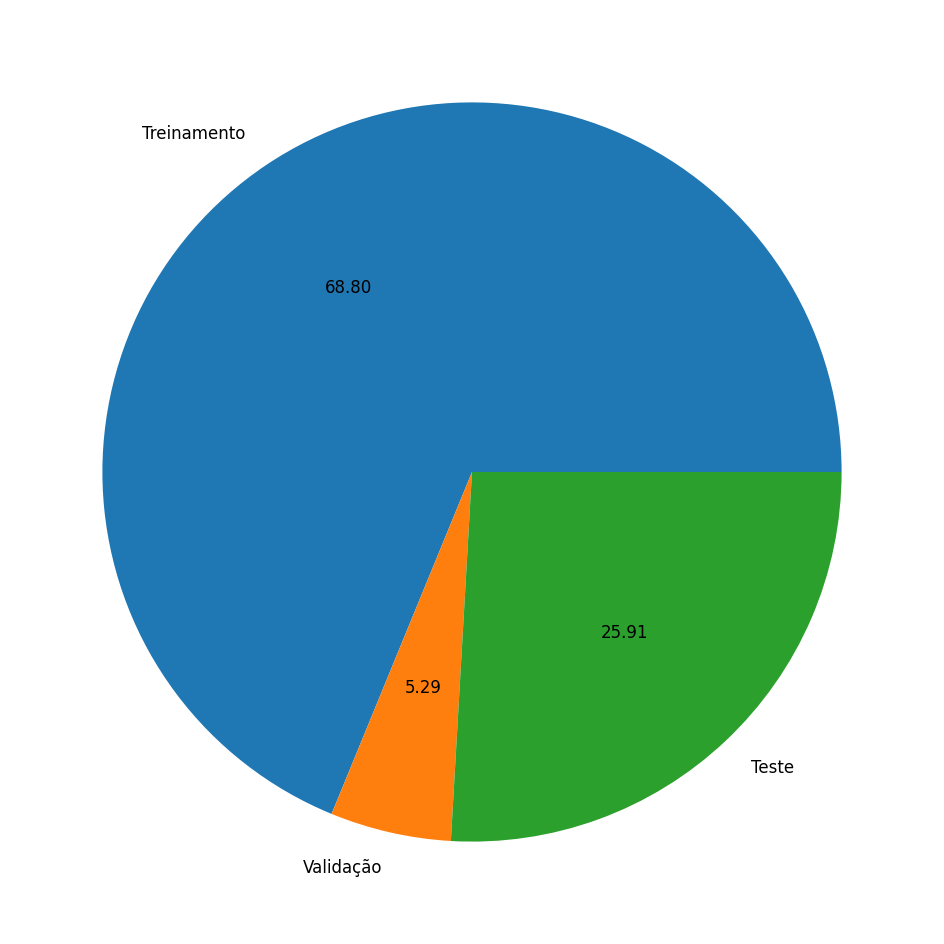

In [ ]:
train_size = dataset['train'].num_rows
val_size = dataset['validation'].num_rows
test_size = dataset['test'].num_rows

plt.pie([train_size, val_size, test_size], labels=['Treinamento', 'Validação', 'Teste'], autopct='%.2f', textprops={'size': 'large'})
plt.show()

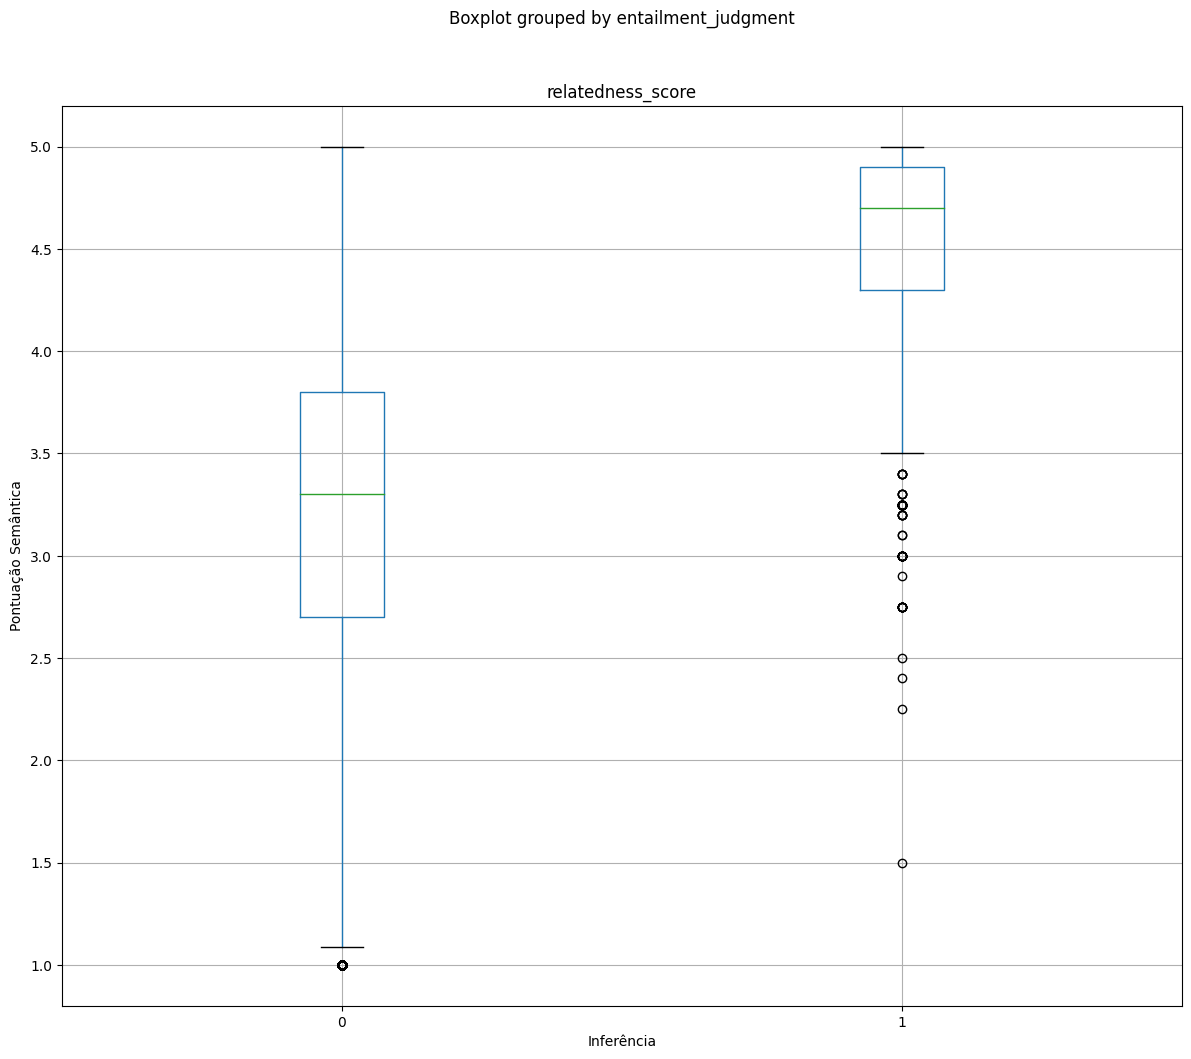

In [ ]:
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

final_df = pd.concat([train_df, val_df, test_df])

final_df.boxplot(column='relatedness_score', by='entailment_judgment')

plt.xlabel('Inferência')
plt.ylabel('Pontuação Semântica')
plt.show()

# Pre-processamento

In [ ]:
def encoder(examples):
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True)
    
def pre_processing(dataset, task=None):
    encoded_dataset = dataset.map(encoder, batched=True)

    if task == 'stsb':
        encoded_dataset = encoded_dataset.map(lambda x: {'label': x['relatedness_score']}, batched=True)
    elif task == 'rte':
        encoded_dataset = encoded_dataset.map(lambda x: {'label': x['entailment_judgment']}, batched=True)
    
    return encoded_dataset

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', model_max_length=train_size)

encode_premise = tokenizer.encode(dataset['train'][0]['premise'])
encode_hypothesis = tokenizer.encode(dataset['train'][0]['hypothesis'])
decode = tokenizer.batch_decode([encode_premise, encode_hypothesis])
print('Codificação:', [encode_premise, encode_hypothesis])
print('Premisa:', decode[0])
print('Hipótese:', decode[1])

Codificação: [[101, 1431, 4964, 3979, 10347, 698, 20373, 230, 16534, 266, 125, 1991, 122, 660, 730, 307, 671, 170, 1991, 102], [101, 1431, 4964, 698, 20373, 230, 16534, 266, 125, 1991, 102]]
Premisa: [CLS] Uma criança risonha está segurando uma pistola de água e sendo espirrada com água [SEP]
Hipótese: [CLS] Uma criança está segurando uma pistola de água [SEP]


# Select Hyperparameters

In [ ]:
train_stsb_names = ['loss', 'val_loss', 'pearsonr', 'id', 'batch_size', 'learning_rate']
test_stsb_names = ['pearsonr', 'loss', 'id', 'batch_size', 'learning_rate']

train_rte_names = ['loss', 'val_loss', 'accuracy', 'f1', 'id', 'batch_size', 'learning_rate']
test_rte_names = ['accuracy', 'f1', 'loss', 'id', 'batch_size', 'learning_rate']

train_stsb = pd.read_csv(f'./drive/MyDrive/models/train_stsb.csv', names=train_stsb_names)
test_stsb = pd.read_csv(f'./drive/MyDrive/models/test_stsb.csv', names=test_stsb_names)

train_rte = pd.read_csv(f'./drive/MyDrive/models/train_rte.csv', names=train_rte_names)
test_rte = pd.read_csv(f'./drive/MyDrive/models/test_rte.csv', names=test_rte_names)

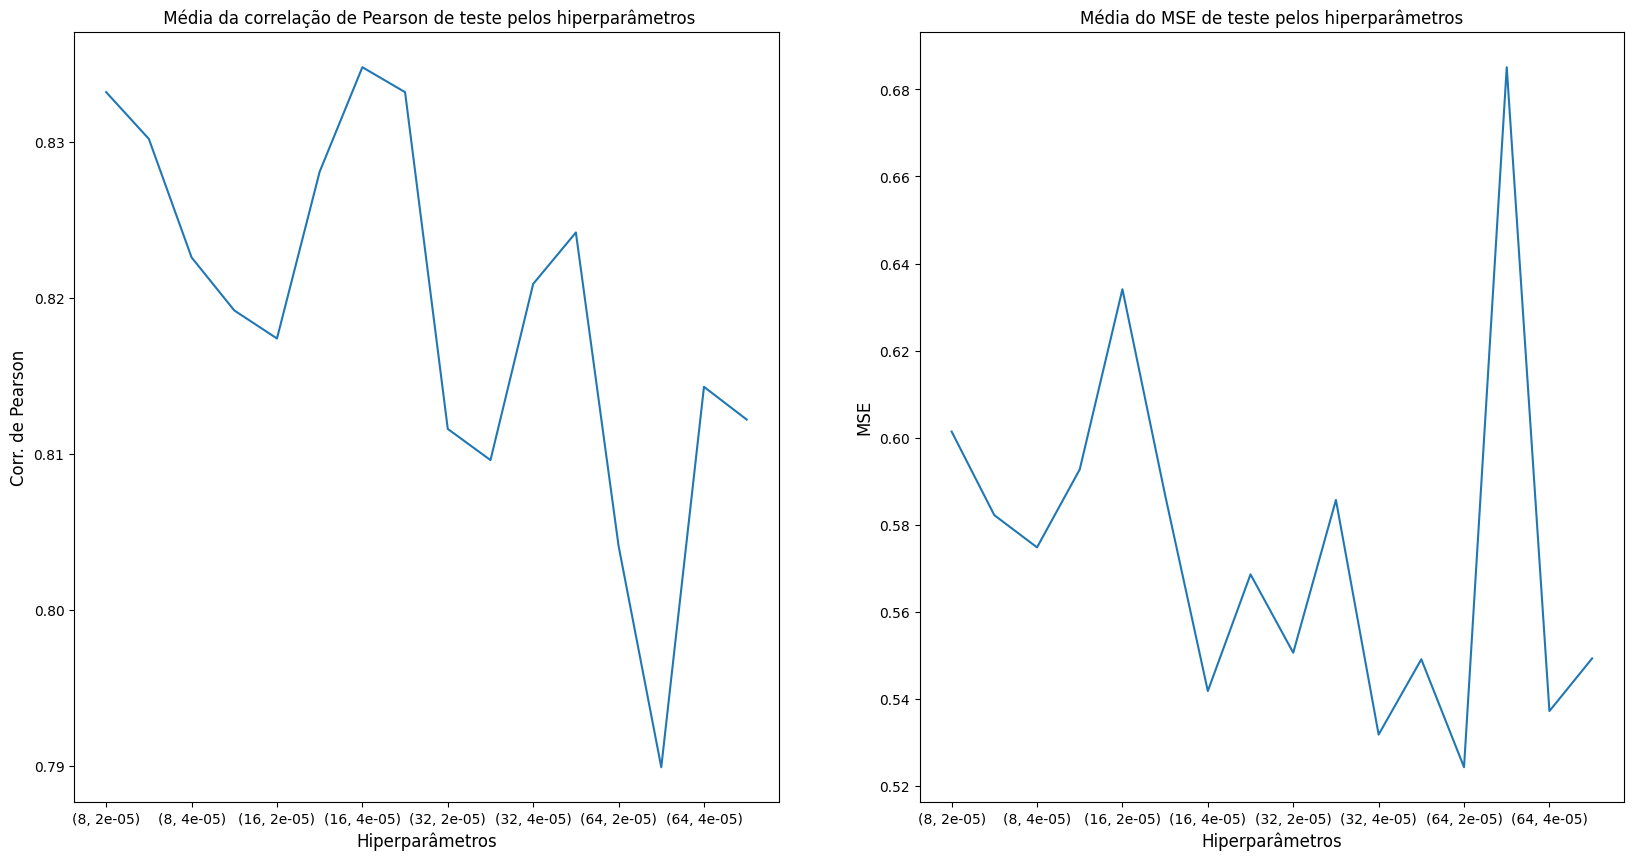

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

pearson_mean = round(test_stsb.groupby(['batch_size', 'learning_rate'])['pearsonr'].mean(), 4)
loss_mean =  round(test_stsb.groupby(['batch_size', 'learning_rate'])['loss'].mean(), 4)
pearson_mean.plot.line(ax=ax1)
loss_mean.plot.line(ax=ax2)
# for x,y in zip(range(len(pearson_mean) + 1), pearson_mean):
#     plt.text(x,y,y,fontsize=12)

# plt.ylabel('Pearson corr', fontsize=12)

ax1.set_ylabel('Corr. de Pearson', fontsize=12)
ax1.set_xlabel('Hiperparâmetros', fontsize=12)
ax1.set_title(' Média da correlação de Pearson de teste pelos hiperparâmetros')

ax2.set_ylabel('MSE', fontsize=12)
ax2.set_xlabel('Hiperparâmetros', fontsize=12)
ax2.set_title('Média do MSE de teste pelos hiperparâmetros')

plt.xlabel
plt.show()

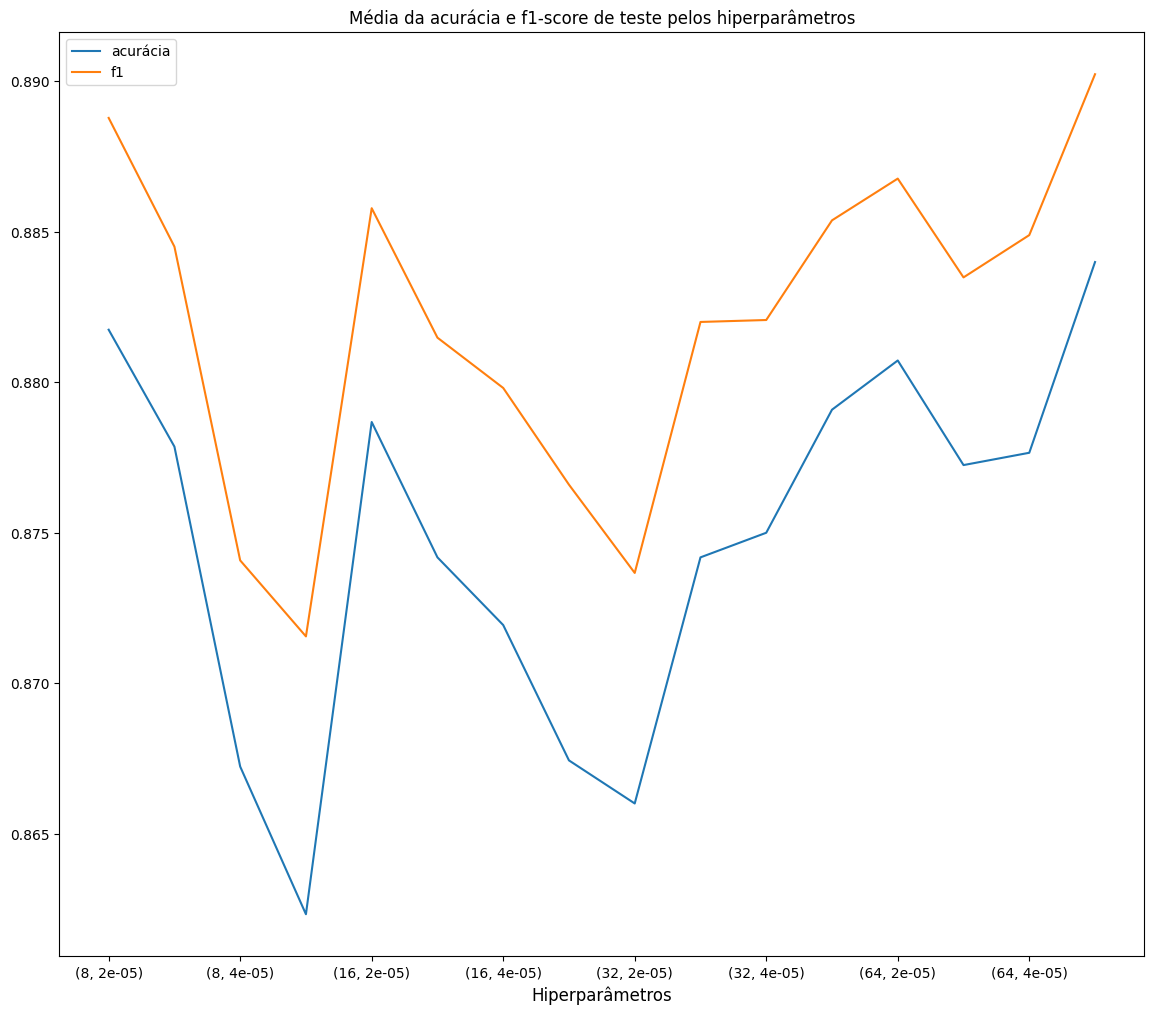

In [ ]:
metrics_mean = test_rte.rename({'accuracy': 'acurácia'}, axis=1)

metrics_mean = metrics_mean.groupby(['batch_size', 'learning_rate'])[['acurácia', 'f1']].mean()

metrics_mean.plot.line()

plt.xlabel('Hiperparâmetros', fontsize=12)
plt.title('Média da acurácia e f1-score de teste pelos hiperparâmetros')
plt.show()

# Fine-tuning

Huggingface Login

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Git config for upload model

In [ ]:
# Config git
!apt install git-lfs
!git config --global user.email "pmfsl@cin.ufpe.br"
!git config --global user.name "Pedro Sena"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-525
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
def load_metrics(task):
    if task == 'stsb':
        metrics = evaluate.load('pearsonr')
    else:
        metrics = evaluate.combine(['accuracy', 'f1'])
    
    return metrics

def load_model(model_checkpoint, total_train_steps, task, learning_rate):
    optimizer, schedule = create_optimizer(
        init_lr=learning_rate, num_warmup_steps=0, num_train_steps=total_train_steps
    )

    if task == 'stsb':
        model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1, from_pt=False)
        model.compile(
            optimizer=optimizer,
            loss='mse'
        )
    else:
        id2label = {0: "None", 1: "Entails"}
        label2id = {"None": 0, "Entails": 1}
        
        model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint,
                                          num_labels=2,
                                          id2label=id2label, 
                                          label2id=label2id,
                                          from_pt=False)   
        model.compile(
                optimizer=optimizer,
        )
            
    return model

def load_tf_dataset(dataset, model, data_collator, batch_size, shuffle):
    tf_dataset = model.prepare_tf_dataset(
        dataset,
        shuffle=shuffle,
        batch_size=batch_size,
        collate_fn=data_collator,
    )

    return tf_dataset

def load_results(model, labels, task, tf_dataset):
    metrics = load_metrics(task)

    loss = model.evaluate(tf_dataset)
    predictions = model.predict(tf_dataset)
    
    if task == "stsb":
        predictions = predictions[0][:, 0]
    else:
        predictions = np.argmax(predictions[0], axis=1)

    results = metrics.compute(predictions=predictions, references=labels)
    results['loss'] = loss

    return results, predictions

def load_callbacks(model_name, task, validation_set, tokenizer):
    metrics = MetricsCallback(task)
    metrics_callback = KerasMetricCallback(
        metric_fn=metrics.compute, eval_dataset=validation_set
    )

    push_to_hub_callback = PushToHubCallback(
        output_dir=f'./{model_name}',
        tokenizer=tokenizer,
        hub_model_id=model_name,
        save_strategy="no"
    )

    callbacks = [metrics_callback, push_to_hub_callback]
    
    return callbacks

In [ ]:
class MetricsCallback:
    def __init__(self, task):
        self.task = task
        self.metrics = load_metrics(task)
    
    def compute(self, eval_predictions):
        predictions, labels = eval_predictions
        if self.task == "stsb":
            predictions = predictions[:, 0]
        else:
            predictions = np.argmax(predictions, axis=1)

        return self.metrics.compute(predictions=predictions, references=labels)

In [ ]:
def plot_confusion_matrix(labels, predictions, p=0.5):
  matrix = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(matrix, annot=True, fmt="d")
  plt.title('Matriz de Confusão @{:.2f}'.format(p))
  plt.ylabel('Classe')
  plt.xlabel('Preds')
  plt.show()

bertimbau-base-finetuned-rte


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Cloning https://huggingface

Epoch 1/5
101/101 [==============================] - 132s 801ms/step - loss: 0.3846 - val_loss: 0.2204 - accuracy: 0.9152 - f1: 0.9191
Epoch 2/5
101/101 [==============================] - 69s 678ms/step - loss: 0.1981 - val_loss: 0.1577 - accuracy: 0.9442 - f1: 0.9455
Epoch 3/5
101/101 [==============================] - 69s 682ms/step - loss: 0.1026 - val_loss: 0.1348 - accuracy: 0.9509 - f1: 0.9511
Epoch 4/5
101/101 [==============================] - 70s 690ms/step - loss: 0.0593 - val_loss: 0.1492 - accuracy: 0.9531 - f1: 0.9542
Epoch 5/5
101/101 [==============================] - 68s 671ms/step - loss: 0.0326 - val_loss: 0.1834 - accuracy: 0.9531 - f1: 0.9534


Upload file tf_model.h5:   0%|          | 1.00/416M [00:00<?, ?B/s]

To https://huggingface.co/pmfsl/bertimbau-base-finetuned-rte
   60c8e1f..af1344d  main -> main

   60c8e1f..af1344d  main -> main



39/39 [==============================] - 13s 241ms/step
bertimbau-base-finetuned-rte test results: {'accuracy': 0.877859477124183, 'f1': 0.8860083873427372, 'loss': 0.5694759488105774}


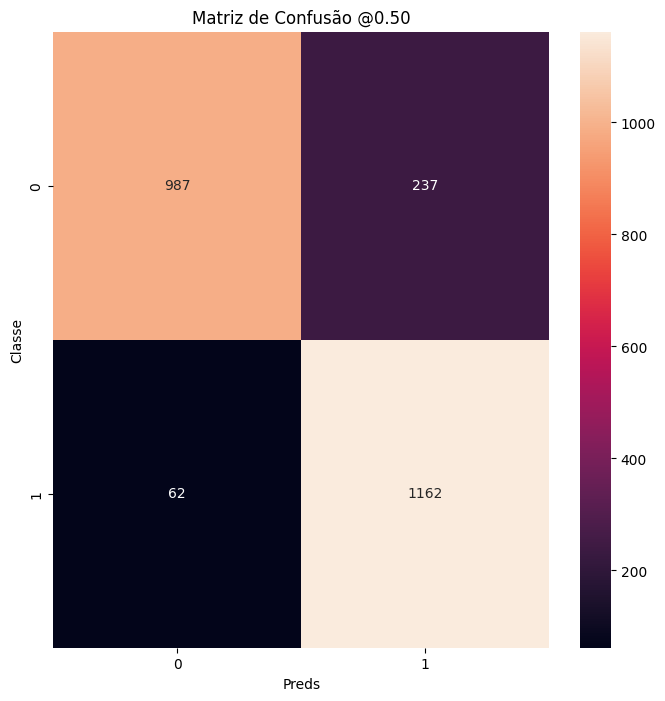

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

bertimbau-base-finetuned-stsb


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cloning https://huggingface.co/pmfsl/bertimbau-base-finetuned-stsb into local empty directory.


Epoch 1/5
406/406 [==============================] - 154s 250ms/step - loss: 0.5258 - val_loss: 0.2748 - pearsonr: 0.8880
Epoch 2/5
406/406 [==============================] - 74s 183ms/step - loss: 0.1468 - val_loss: 0.1877 - pearsonr: 0.9214
Epoch 3/5
406/406 [==============================] - 74s 181ms/step - loss: 0.0985 - val_loss: 0.1370 - pearsonr: 0.9419
Epoch 4/5
406/406 [==============================] - 73s 180ms/step - loss: 0.0704 - val_loss: 0.1465 - pearsonr: 0.9456
Epoch 5/5
406/406 [==============================] - 72s 178ms/step - loss: 0.0553 - val_loss: 0.1474 - pearsonr: 0.9486


Upload file tf_model.h5:   0%|          | 1.00/416M [00:00<?, ?B/s]

To https://huggingface.co/pmfsl/bertimbau-base-finetuned-stsb
   1e00676..1922d32  main -> main

   1e00676..1922d32  main -> main



153/153 [==============================] - 14s 64ms/step
bertimbau-base-finetuned-stsb test results: {'pearsonr': 0.8432714006694431, 'loss': 0.6170313954353333}


Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

mbert-base-finetuned-pt_br-rte


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Cloning https://huggingface.co/pmfsl/mbert-base-finetuned-pt_br-rte into local empty directory

Epoch 1/5
101/101 [==============================] - 141s 918ms/step - loss: 0.4070 - val_loss: 0.2690 - accuracy: 0.8884 - f1: 0.8922
Epoch 2/5
101/101 [==============================] - 80s 796ms/step - loss: 0.2460 - val_loss: 0.2288 - accuracy: 0.9286 - f1: 0.9304
Epoch 3/5
101/101 [==============================] - 78s 776ms/step - loss: 0.1722 - val_loss: 0.1869 - accuracy: 0.9263 - f1: 0.9287
Epoch 4/5
101/101 [==============================] - 79s 783ms/step - loss: 0.1098 - val_loss: 0.2032 - accuracy: 0.9308 - f1: 0.9310
Epoch 5/5
101/101 [==============================] - 78s 774ms/step - loss: 0.0664 - val_loss: 0.2401 - accuracy: 0.9286 - f1: 0.9279


Upload file tf_model.h5:   0%|          | 1.00/679M [00:00<?, ?B/s]

To https://huggingface.co/pmfsl/mbert-base-finetuned-pt_br-rte
   e372330..28e789c  main -> main

   e372330..28e789c  main -> main



39/39 [==============================] - 14s 281ms/step
mbert-base-finetuned-pt_br-rte test results: {'accuracy': 0.8668300653594772, 'f1': 0.8755725190839695, 'loss': 0.47704824805259705}


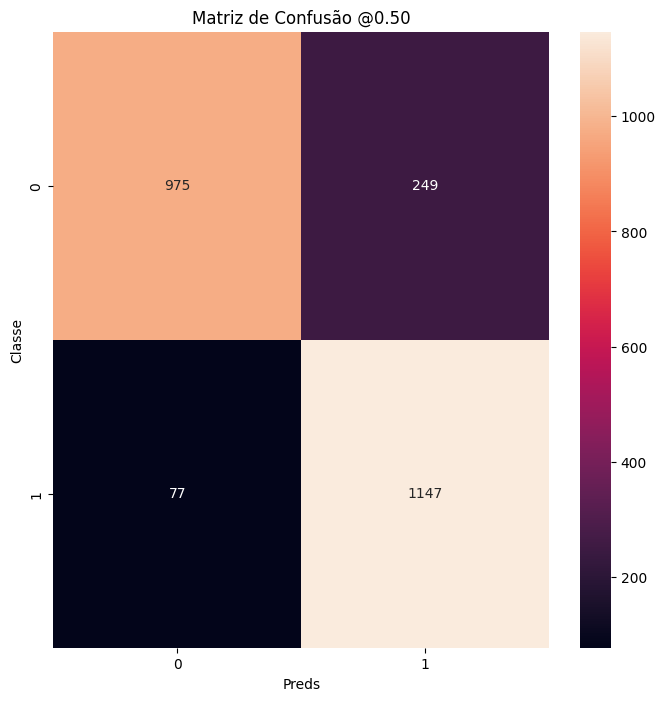

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

mbert-base-finetuned-pt_br-stsb


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Cloning https://huggingface.co/pmfsl/mbert-base-finetuned-pt_br-stsb into local empty directory.


Epoch 1/5
406/406 [==============================] - 158s 272ms/step - loss: 0.8113 - val_loss: 0.4476 - pearsonr: 0.7836
Epoch 2/5
406/406 [==============================] - 88s 217ms/step - loss: 0.2637 - val_loss: 0.2973 - pearsonr: 0.8437
Epoch 3/5
406/406 [==============================] - 86s 212ms/step - loss: 0.1819 - val_loss: 0.2807 - pearsonr: 0.8646
Epoch 4/5
406/406 [==============================] - 85s 210ms/step - loss: 0.1334 - val_loss: 0.2370 - pearsonr: 0.8835
Epoch 5/5
406/406 [==============================] - 85s 210ms/step - loss: 0.1085 - val_loss: 0.2331 - pearsonr: 0.8853


Upload file tf_model.h5:   0%|          | 1.00/679M [00:00<?, ?B/s]

To https://huggingface.co/pmfsl/mbert-base-finetuned-pt_br-stsb
   2295466..7d9dba8  main -> main

   2295466..7d9dba8  main -> main



153/153 [==============================] - 15s 72ms/step
mbert-base-finetuned-pt_br-stsb test results: {'pearsonr': 0.7949640538912515, 'loss': 0.5991967916488647}


In [ ]:
NUM_EPOCHS = 5

MODELS = [
    {
        "id": "bertimbau-base-finetuned",
        "checkpoint": "neuralmind/bert-base-portuguese-cased"
    },
    {
        "id": "mbert-base-finetuned-pt_br",
        "checkpoint": "bert-base-multilingual-cased"
    }
]

configs = [
    {
        'task': 'rte',
        'learning_rate': 5e-5,
        'batch': 64
    },
    {
        'task': 'stsb',
        'learning_rate': 4e-5,
        'batch': 16
    }
]

for m in MODELS:
    tokenizer = AutoTokenizer.from_pretrained(m['checkpoint'], model_max_length=train_size)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
    for c in configs:
        encoded_dataset = pre_processing(dataset, c['task'])
        batches_per_epoch = train_size // c['batch']
        total_train_steps = int(batches_per_epoch * NUM_EPOCHS)

        # init model
        model_name = "{}-{}".format(m['id'], c['task'])
        print(model_name)
        
        model = load_model(m['checkpoint'], total_train_steps, c['task'], c['learning_rate'])
        
        # set dataset to tensor
        tf_train_set = load_tf_dataset(encoded_dataset['train'], model, data_collator, c['batch'], shuffle=True)
        tf_validation_set = load_tf_dataset(encoded_dataset['validation'], model, data_collator, c['batch'], shuffle=True)
        tf_test_set = load_tf_dataset(encoded_dataset['test'], model, data_collator, c['batch'], shuffle=False)

        callbacks = load_callbacks(model_name, c['task'], tf_validation_set, tokenizer)

        # training
        model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=NUM_EPOCHS, callbacks=callbacks)
        
        labels = encoded_dataset['test']['label']
        test_results, predictions = load_results(model, labels, c['task'], tf_test_set)
        print(f'{model_name} test results: {test_results}')
        if c['task'] == 'rte':
            plot_confusion_matrix(labels, predictions)
